In [1]:
from tqdm.notebook import tqdm
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    #T.Lambda(lambda x: x.to(device)),
])

DATASET_ROOT = 'data/'
data_train = CIFAR10(
    root = DATASET_ROOT,
    train=True,
    download=True,
    transform=preprocess,
    #target_transform=T.Lambda(lambda x: x.to(device)),
)

data_test = CIFAR10(
    root = DATASET_ROOT,
    train=False,
    download=False,
    transform=preprocess,
    #target_transform=T.Lambda(lambda x: x.to(device)),
)

Files already downloaded and verified


In [3]:
from torch.utils.data import DataLoader, Subset
BATCH_SIZE = 32
train_dl = DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
)

test_dl = DataLoader(
    data_test,
    batch_size=BATCH_SIZE
)

In [4]:
import os
NET_DIR = 'vgg16'
os.makedirs(NET_DIR, exist_ok=True)

from torch.hub import load
from torch import nn
VISION_REPO = 'pytorch/vision'
model = load(VISION_REPO, NET_DIR, pretrained=False)

Using cache found in C:\Users\ensmi/.cache\torch\hub\pytorch_vision_master


In [5]:
classifiers = list(model.classifier)
classifiers[-1] = nn.Linear(in_features=4096, out_features=10)
model.classifier = nn.Sequential(*classifiers)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
def trainModel():

    EPOCHS = 90
    MOMENTUM = 0.9
    LR_INIT = 0.001
    LR_DECAY = 0.0005

    # training init
    model.train()
    seed = torch.initial_seed()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=LR_INIT,
        momentum=MOMENTUM,
        weight_decay=LR_DECAY
    )

    # progress bars nest
    for epoch in tqdm(range(EPOCHS), unit='epoch'):

        # load from file if exists, skip computing if already done
        cur_epoch_file = f'{NET_DIR}/e{epoch}.pkl'
        if os.path.exists(cur_epoch_file):
            pickle_dict = torch.load(cur_epoch_file)
            seed = pickle_dict['seed']
            torch.manual_seed(seed)
            model.load_state_dict(pickle_dict['model'])
            optimizer.load_state_dict(pickle_dict['optim'])
            continue

        # perform epoch
        loss = 0.0
        for img, label in tqdm(train_dl, unit='batch', leave=False):
            optimizer.zero_grad()

            output = model(img.to(device))
            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()

        # save state in case we're interrupted
        if epoch % 15 == 0:
            print(f'Epoch {epoch}/{EPOCHS}, loss = {loss.item():.3f}')
            state = {
                'optim': optimizer.state_dict(),
                'model': model.state_dict(),
                'seed': seed
            }
            torch.save(state, cur_epoch_file)

# load from file if already trained, otherwise train and save
MODEL_FILE = f'{NET_DIR}/cifar10_attr.pkl'
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE))
else:
    trainModel()
    torch.save(model.state_dict(), MODEL_FILE)

In [7]:
correct = 0
total = 0

model.eval()
for i in range(0, 90, 15):
    intermediate = torch.load(f'{NET_DIR}/e{i}.pkl')
    model.load_state_dict(intermediate['model'])
    with torch.no_grad():
        correct = 0
        total = 0
        for img, label in tqdm(train_dl, unit='batch'):
            output = model(img.to(device))
            total += label.size(0)
            _, prediction = torch.max(output.data, 1)
            correct += (prediction == label.to(device)).sum().item()
        print(f'Training: Got {correct}/{total} correct at epoch {i}')
        print(f'Training: Accuracy of {NET_DIR} at epoch {i} on attributes is {100 * correct / total:.3f}%')
        correct = 0
        total = 0

        for img, label in tqdm(test_dl, unit='batch'):
            output = model(img.to(device))
            total += label.size(0)
            _, prediction = torch.max(output.data, 1)
            correct += (prediction == label.to(device)).sum().item()
        print(f'Testing: Got {correct}/{total} correct at epoch {i}')
        print(f'Testing: Accuracy of {NET_DIR} at epoch {i} on attributes is {100 * correct / total:.3f}%')



Training: Got 21073/50000 correct at epoch 0
Training: Accuracy of vgg16 at epoch 0 on attributes is 42.146%

Testing: Got 4254/10000 correct at epoch 0
Testing: Accuracy of vgg16 at epoch 0 on attributes is 42.540%

Training: Got 49051/50000 correct at epoch 15
Training: Accuracy of vgg16 at epoch 15 on attributes is 98.102%

Testing: Got 7703/10000 correct at epoch 15
Testing: Accuracy of vgg16 at epoch 15 on attributes is 77.030%

Training: Got 49829/50000 correct at epoch 30
Training: Accuracy of vgg16 at epoch 30 on attributes is 99.658%

Testing: Got 7727/10000 correct at epoch 30
Testing: Accuracy of vgg16 at epoch 30 on attributes is 77.270%

Training: Got 49995/50000 correct at epoch 45
Training: Accuracy of vgg16 at epoch 45 on attributes is 99.990%

Testing: Got 7956/10000 correct at epoch 45
Testing: Accuracy of vgg16 at epoch 45 on attributes is 79.560%

Training: Got 49989/50000 correct at epoch 60
Training: Accuracy of vgg16 at epoch 60 on attributes is 99.978%

Testing

In [8]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for img, label in tqdm(train_dl, unit='batch'):
        output = model(img.to(device))
        total += label.size(0)
        _, prediction = torch.max(output.data, 1)
        correct += (prediction == label.to(device)).sum().item()

print(f'Got {correct}/{total} correct')
print(f'Accuracy of {NET_DIR} on attributes is {100 * correct / total:.3f}%')


Got 49995/50000 correct
Accuracy of vgg16 on attributes is 99.990%


In [9]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_dl, unit='batch'):
        output = model(img.to(device))
        total += label.size(0)
        _, prediction = torch.max(output.data, 1)
        correct += (prediction == label.to(device)).sum().item()

print(f'Got {correct}/{total} correct')
print(f'Accuracy of {NET_DIR} on attributes is {100 * correct / total:.3f}%')


Got 7896/10000 correct
Accuracy of vgg16 on attributes is 78.960%


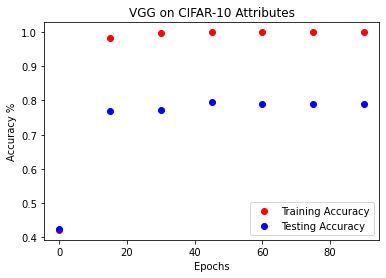

In [1]:
import matplotlib.pyplot as plt

MIN_X = 0
MAX_X = 90
NET_NAME = 'VGG'
DATASET_NAME = 'CIFAR-10 Attributes'
LEGEND_LOC = 'lower right'

train_x = [0, 15, 30, 45, 60, 75, 90]  # training epoch numbers
train_y = [0.422, 0.981, 0.997, 0.999, 0.999, 0.999, 0.999]  # training error values (percent form)
test_x = train_x[:]  # testing epoch numbers
test_y = [0.425, 0.770, 0.773, 0.796, 0.789, 0.790, 0.790]  # testing epoch numbers (percent form)

################# STOP HERE ################

assert len(train_x) == len(train_y)
assert len(test_x) == len(test_y)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)

ax.set_title(f'{NET_NAME} on {DATASET_NAME}')

ax.scatter(train_x, train_y, c='r', label='Training Accuracy')
ax.scatter(test_x, test_y, c='b', label='Testing Accuracy')

ax.set_xlabel(f'Epochs')
ax.set_ylabel(f'Accuracy %')

ax.legend(loc=LEGEND_LOC)

plt.savefig(
    f'{NET_NAME.lower().replace("-", "")}-{DATASET_NAME.lower().replace(" ", "-")}.png',
    transparent=False
)
